### Introduction
Ultimate goal is to build a predictive model to estimate grades of students based on a certain set of features. The purpose of this notebook is to have a good understanding of the data that will give us an intuition on what approach should work best. Every analysis will be done with the goal of understanding the data to build a model, this is not a descriptibe analysis: there are already some good kernels for that, and I see little value in repeating what others have done.


Analysis include:
- Data size and populations. How much data we have available to develop the model. What populations have been identified, and how many models we need to run. If we have more than one population, we might need more than one model. In this case, we know there are two populations (Math Students and Portuguese students). We can train one model for the two, or two separate models
- Data quality. Here we check how good our data is. Outlayers, NAs, distribution of variables, redundant information, intersections between populations, duplicates, etc
- Some other ad-hoc questions specific to this use case that might come up

### Imports

In [1]:
# Immports
library(data.table) # For data manipulation
library(ggplot2)    # For plots
library(magrittr)   # For pipe operator  %>% 
library(dummies)    # To convert categorical to binary 

# Global options
options(repr.matrix.max.cols=200, repr.matrix.max.rows=250)

dummies-1.5.6 provided by Decision Patterns



### Reading data

In [2]:
# Reading data for both subjects
# Grades for math students
dataset_math <- fread("./../data/student-mat.csv",sep=",",header=TRUE)
# Grades for portuguese students
dataset_port <- fread("./../data/student-por.csv",sep=",",header=TRUE)

### Populations
There are two populations, Math and Portuguese students. We will look at the intersection of both populations
- We will use the columns especified by the creator of this dataset as unique identifiers, although there are also duplicated columns that are not used for the  inner join
- There are  more portuguese students than math students
- Most Math students also take Portuguese 382 out of 395

In [3]:
by_cols <- c("school","sex","age","address","famsize","Pstatus","Medu","Fedu",
             "Mjob","Fjob","reason","nursery","internet")

a <- dataset_math[, (by_cols), with=F]
b <- dataset_port[, (by_cols), with=F]
a[, flag_math:=1]
b[, flag_port:=1]

# Getting intersection of populations
intersection <- merge(a,b,by=by_cols, all=T)

# Printing results
print(paste("N. Math students:", a %>%  nrow))
print(paste("N. Portuguese students:", b %>%  nrow))
intersection[  ,.N, .(flag_math, flag_port)]

rm(a,b)

[1] "N. Math students: 395"
[1] "N. Portuguese students: 649"


flag_math,flag_port,N
1,1,382
NA,1,275
1,NA,25


### Comparing grades for students who attended both courses
- Normally, students who do well in one subject will also do well in the other
- Portuguese grades are a bit higher than Math grades
- We can see that, as the year progresses, there are more students that drop out math than students that drop out Portuguese

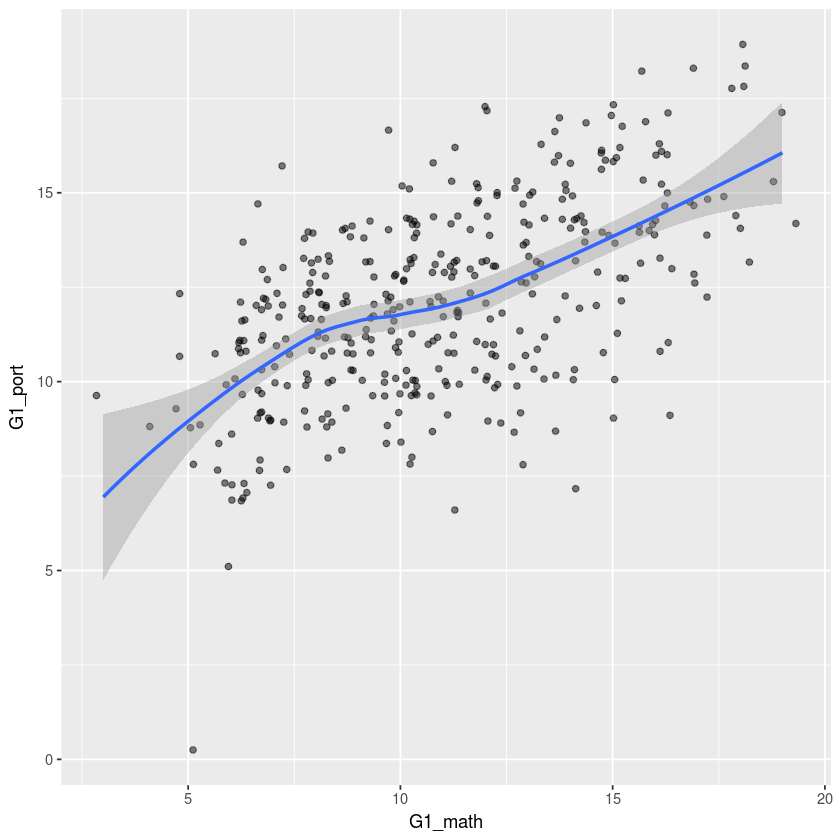

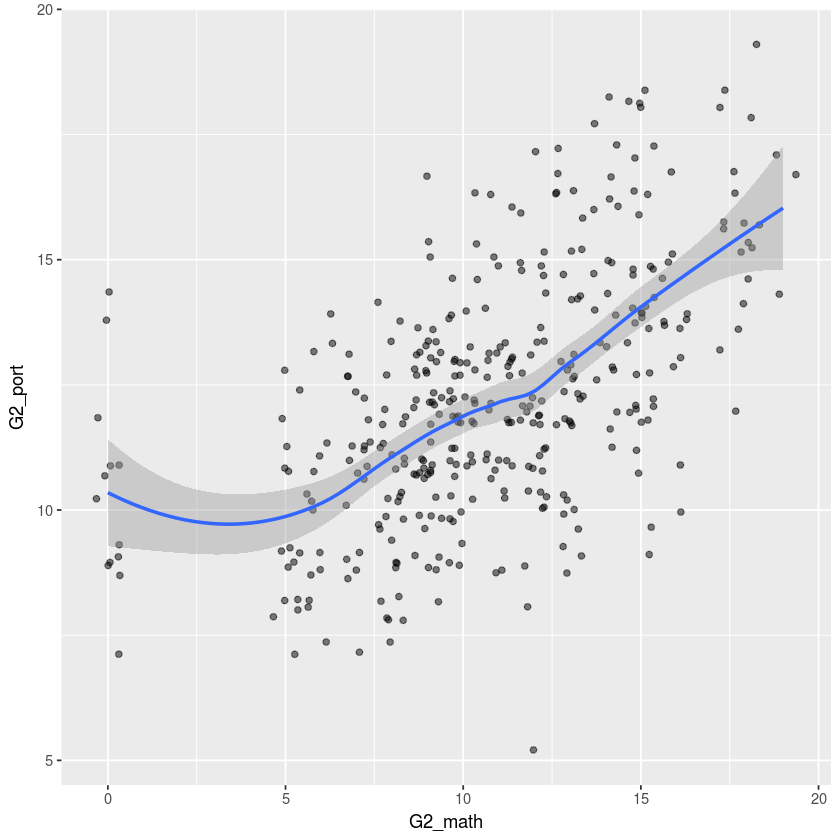

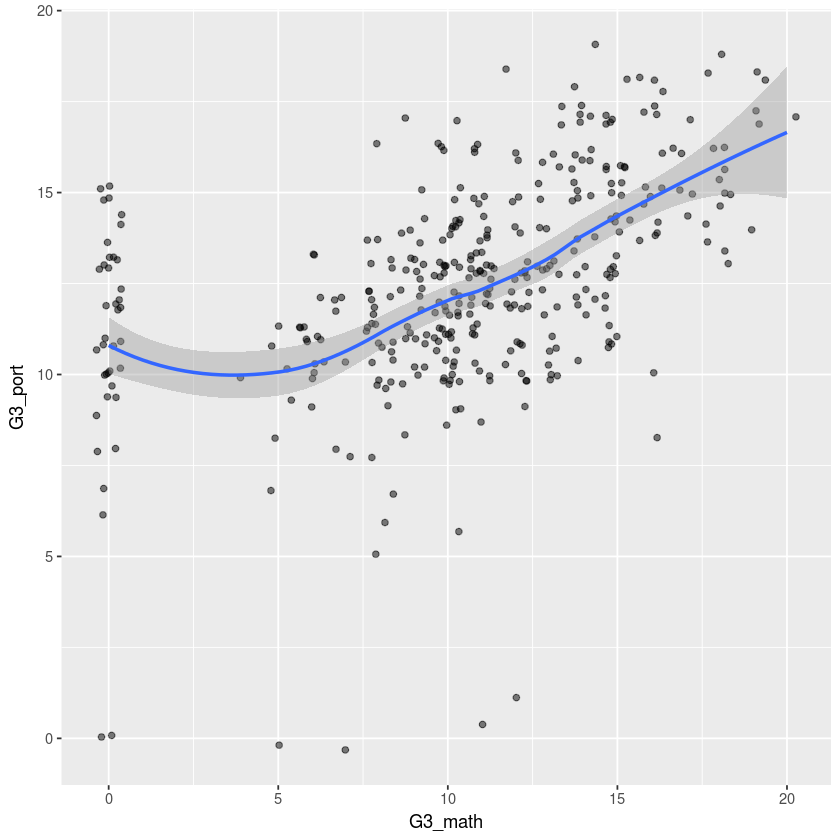

In [4]:
dataset_inner <- merge(dataset_math,dataset_port,by=by_cols)

# Changing names
x_names <- grep(names(dataset_inner), pattern = "\\.x", value = T)
y_names <- grep(names(dataset_inner), pattern = "\\.y", value = T)
setnames(dataset_inner, x_names, gsub(".x", "_math",x_names))
setnames(dataset_inner, y_names, gsub(".y", "_port",y_names))

# We use geom_jitter instead to geom_point to avoid points stacking on top of eachother,
# because grades are discrete
ggplot(dataset_inner, aes(G1_math, G1_port)) + geom_jitter(alpha=0.5) + geom_smooth(method = 'loess')
ggplot(dataset_inner, aes(G2_math, G2_port)) + geom_jitter(alpha=0.5) + geom_smooth(method = 'loess')
ggplot(dataset_inner, aes(G3_math, G3_port)) + geom_jitter(alpha=0.5) + geom_smooth(method = 'loess')

### Comparing distribution of grades thoughout the year

- Overall, grades are stable throughout the year
- Here we see again students who drop out. 
    - There are more drop-outs as the year goes by. 
    - There are more drop-outs in math

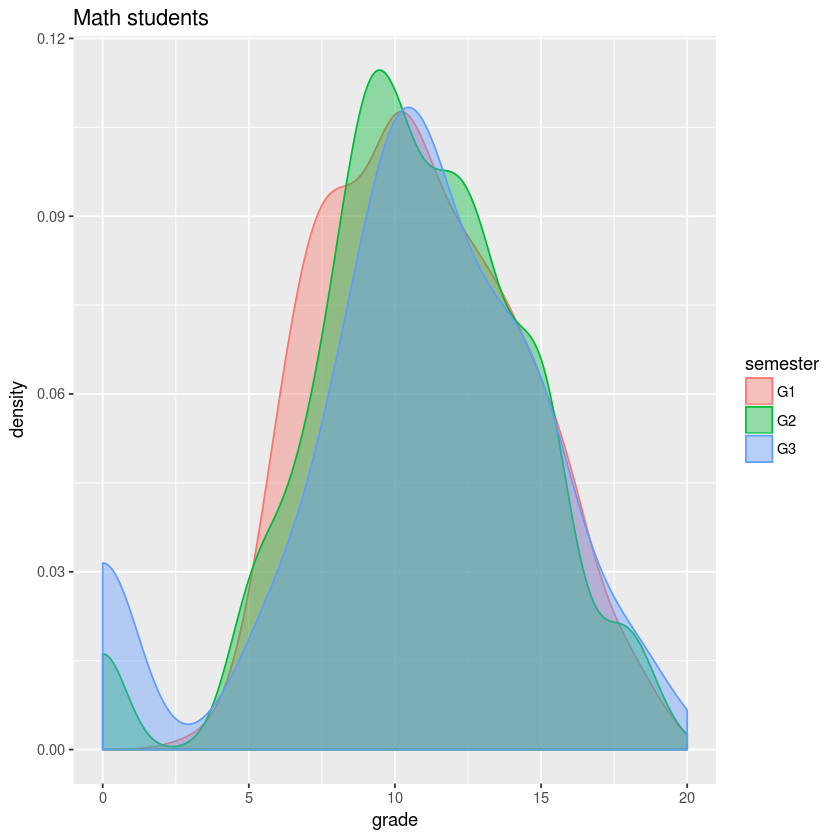

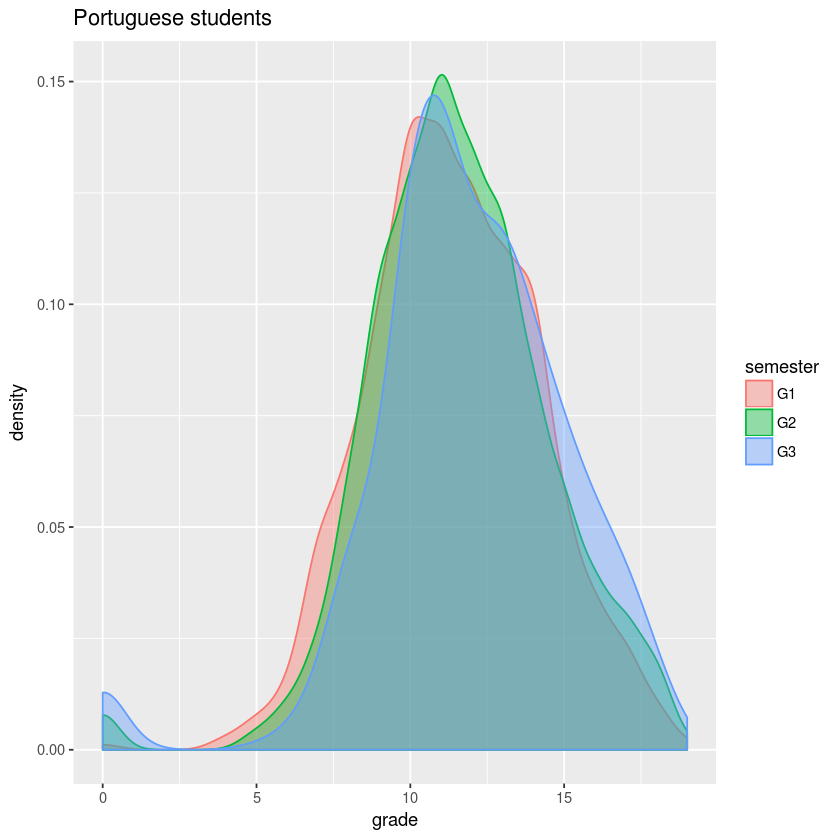

In [5]:
dataset_math[ , id_student := .I]
dataset_port[ , id_student := .I]

grades_math <- dataset_math %>%  melt.data.table(id.vars = "id_student" , measure.vars = paste0("G",1:3), variable.name = "semester", value.name = "grade")
grades_port <- dataset_port %>%  melt.data.table(id.vars = "id_student" , measure.vars = paste0("G",1:3), variable.name = "semester", value.name = "grade")

ggplot(grades_math, aes(x=  grade, color=semester, fill=semester))+ geom_density(alpha=0.4) + ggtitle("Math students")
ggplot(grades_port, aes(x=  grade, color=semester, fill=semester))+ geom_density(alpha=0.4) + ggtitle("Portuguese students")

### Correlation matrix for numeric columns
The further from zero, the better, in both directions, being 1 and -1 the best correlations. That is why we take absolute value. Plotting correlations without absolute values will lead to VERY misleading results, since -1 and 1 would be in oposite sides in the color scale

- No big correlation between variables
- We cannot remove redundant information due to linear correlation
- Grades are highly correlated with eachother, but not woth the rest of variables. That means that a linear method such as linear regression will not work at its best
- Ignore correlation between id_student and age. That is simply because id_student is an incremental and the dataset was partly sorted by age

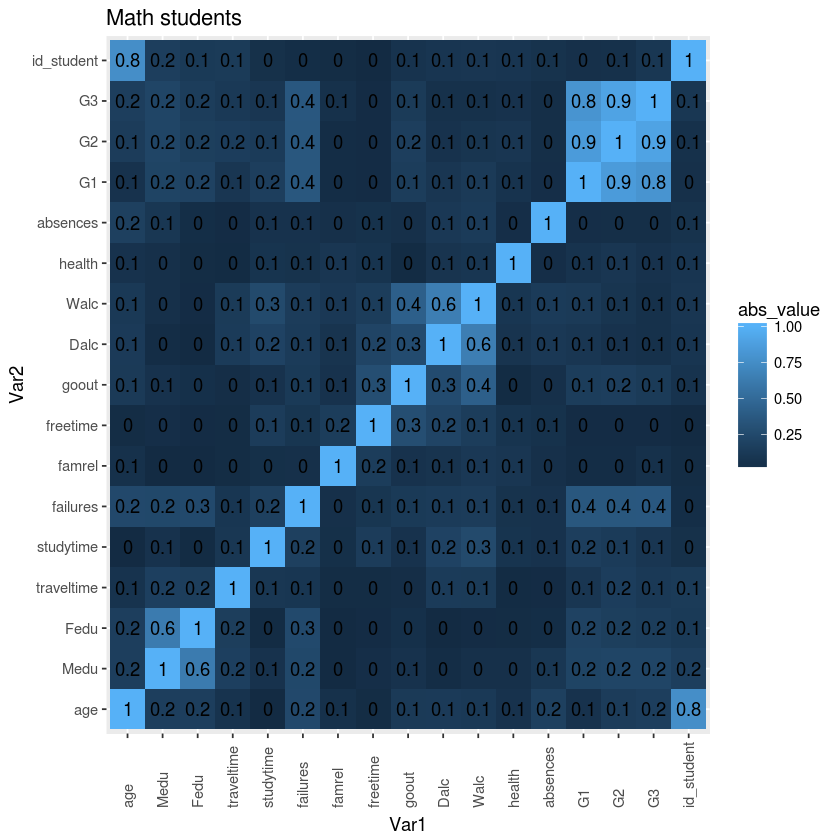

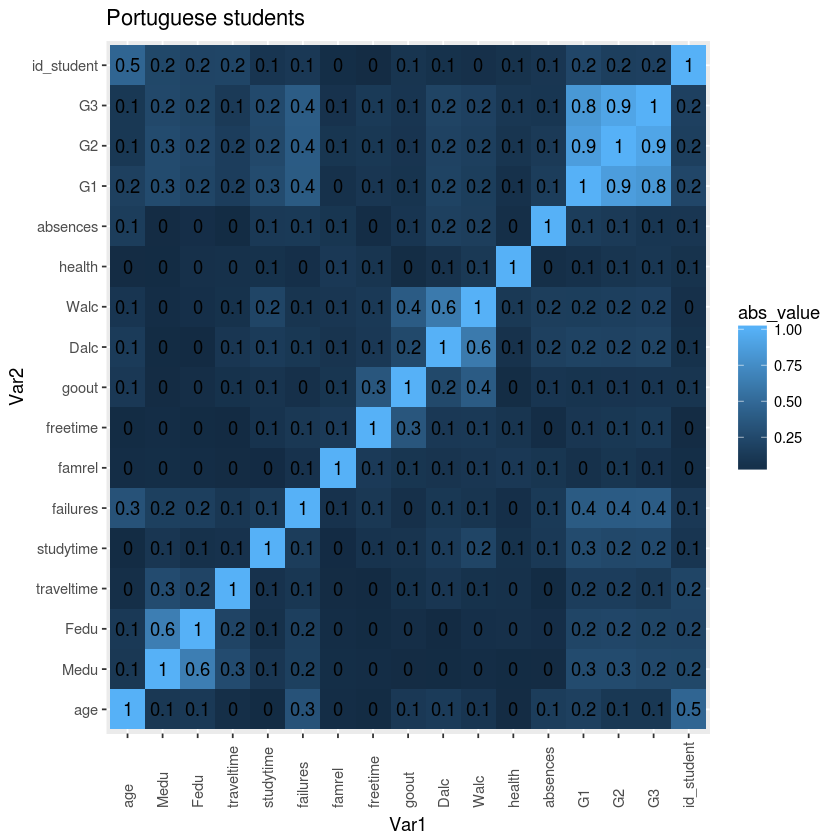

In [12]:
# Identifying numeric columns
col_classes_math <- dataset_math[ , lapply(.SD, class)]
numeric_cols <- names(col_classes_math)[col_classes_math %in% c("integer", "numeric")]

# Correlation matrix for math students
cor_math <- cor(dataset_math[ , (numeric_cols),with=F ])
cor_math <- melt(cor_math)
cor_math <- data.table(cor_math)
cor_math[ , abs_value:=abs(value)]

ggplot(data = cor_math, aes(x=Var1, y=Var2, fill=abs_value)) + 
    geom_tile() +
    geom_text(aes(label = round(abs_value, 1))) +
    theme(axis.text.x = element_text(angle = 90, vjust=0.5, hjust=0)) +
    ggtitle("Math students")

# Correlation matrix for portuguese students
cor_port <- cor(dataset_port[ , (numeric_cols),with=F ])
cor_port <- melt(cor_port)
cor_port <- data.table(cor_port)
cor_port[ , abs_value:=abs(value)]

ggplot(data = cor_port, aes(x=Var1, y=Var2, fill=abs_value)) + 
    geom_tile() +
    geom_text(aes(label = round(abs_value, 1))) +
    theme(axis.text.x = element_text(angle = 90, vjust=0.5, hjust=0)) +
    ggtitle("Portuguese students")

### Correlation matrix for categorical columns
Here we show correlation matrix in melted format in a table. It is easier to analyze tables instead of heat maps when data is too big. Whe one-hot-encode categorical variables to convert them to numeric

Just as before, the further from zero, the better, in both directions, being 1 and -1 the best correlations. That is why we take absolute value

- Same correlations as observed in previous analysis
- We cannot remove redundant information due to linear correlation
- We ignore variables with corr = -1, since those are just categorical variables with exactly two categories, and therefore the relation is exactly linear-inverse. 
- We take up to the 10th decimal point instead to exact equality due to additional very under represented classes like "other" in binary vars
- The variable "guardian" is a good example of this. It commonly has two categories, but in a monirity of cases it has an additional category that makes correlation not be equal to -1

In [7]:
char_cols <- names(col_classes_math)[col_classes_math %in% c("character")]
dummy_math <- dummies::dummy.data.frame(dataset_math[ , c(char_cols, "G1", "G2", "G3") ,with=F ], sep="_")
cor_math <- cor(dummy_math)
cor_math <- melt(cor_math)
cor_math <- data.table(cor_math)


dummy_port <- dummies::dummy.data.frame(dataset_port[ , c(char_cols, "G1", "G2", "G3") ,with=F ], sep="_")
cor_port <- cor(dummy_port)
cor_port <- melt(cor_port)
cor_port <- data.table(cor_port)

cor_math[ , abs_value := abs(value)]
cor_port[ , abs_value := abs(value)]
cor_math %>%  setorder(-abs_value)
cor_port %>%  setorder(-abs_value)

print("Math students")
cor_math[Var1 !=Var2 & round(value, 10)!=-1] %>%  head(20)
print("Portuguese students")
cor_port[Var1 !=Var2 & round(value, 10)!=-1] %>%  head(20)

[1] "Math students"


Var1,Var2,value,abs_value
G3,G2,0.9048680,0.9048680
G2,G3,0.9048680,0.9048680
G2,G1,0.8521181,0.8521181
G1,G2,0.8521181,0.8521181
guardian_mother,guardian_father,-0.8125924,0.8125924
guardian_father,guardian_mother,-0.8125924,0.8125924
G3,G1,0.8014679,0.8014679
G1,G3,0.8014679,0.8014679
Fjob_services,Fjob_other,-0.6902751,0.6902751
Fjob_other,Fjob_services,-0.6902751,0.6902751


[1] "Portuguese students"


Var1,Var2,value,abs_value
G3,G2,0.9185480,0.9185480
G2,G3,0.9185480,0.9185480
G2,G1,0.8649816,0.8649816
G1,G2,0.8649816,0.8649816
guardian_mother,guardian_father,-0.8505693,0.8505693
guardian_father,guardian_mother,-0.8505693,0.8505693
G3,G1,0.8263871,0.8263871
G1,G3,0.8263871,0.8263871
Fjob_services,Fjob_other,-0.7094550,0.7094550
Fjob_other,Fjob_services,-0.7094550,0.7094550


### Unique values per categorical variable
- 13 out of 16 variables are actually binary variables
- For binary variables, we can just label encode them into "0" and "1" and convert them to numeric that way, avoiding one hot encoding
- This is good, because the number of features after dealing with categories will not expand too much
- As a reminder, it is always good to have much more records than features. In small datasets, we always have to watch out for how much we expand the amount of features to keep a good and healthy proportion of recods vs features

In [8]:
print("Math students:")
dataset_math[ , lapply(.SD, uniqueN), .SDcols=char_cols]
print("Portuguese students: ")
dataset_port[ , lapply(.SD, uniqueN), .SDcols=char_cols]

[1] "Math students:"


school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2


[1] "Portuguese students: "


school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2


### Distribution of numeric variables
- No outliers in dataset execept for maybe "absences", although all its values are within a reasonable range 

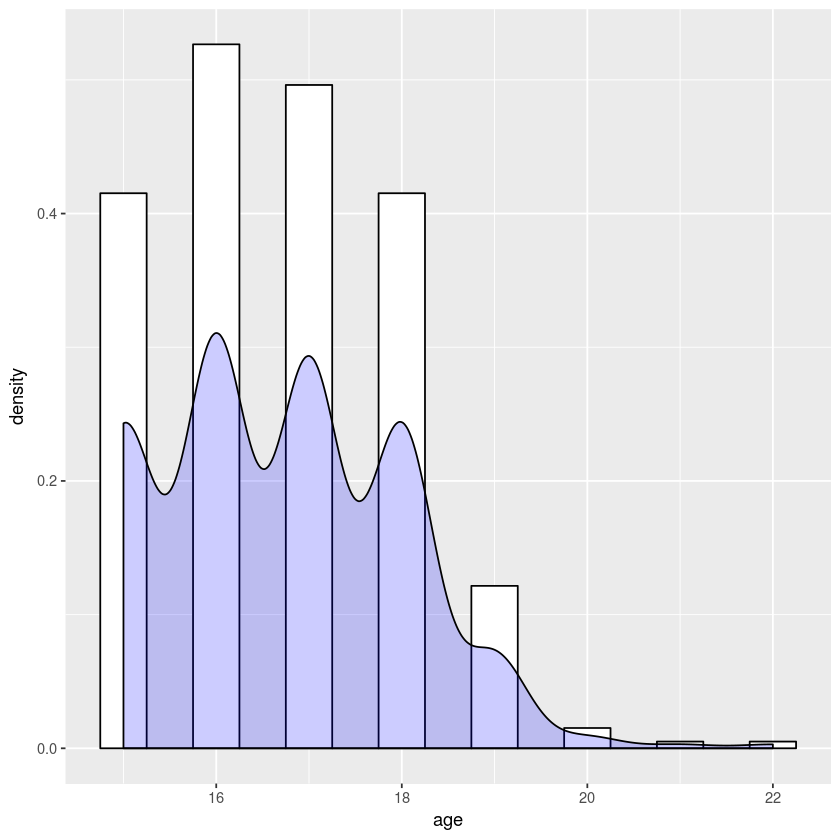

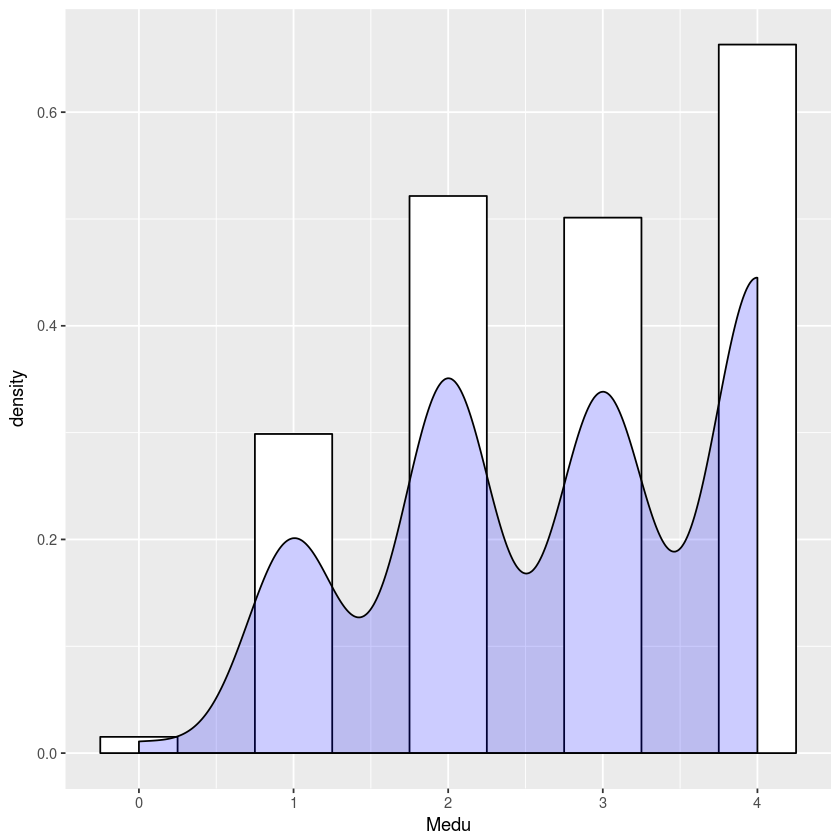

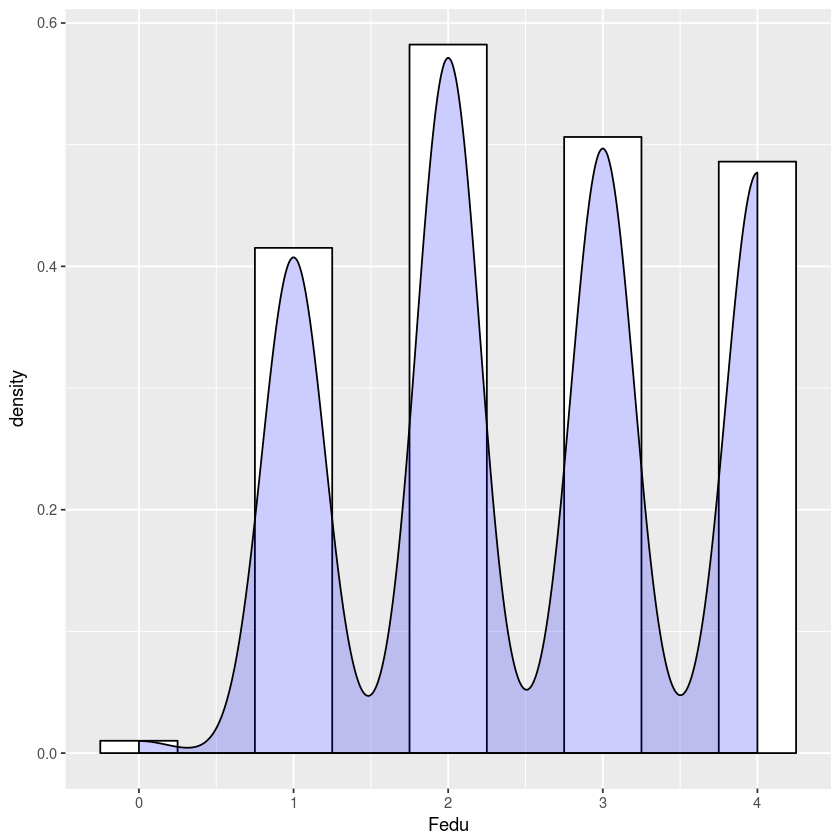

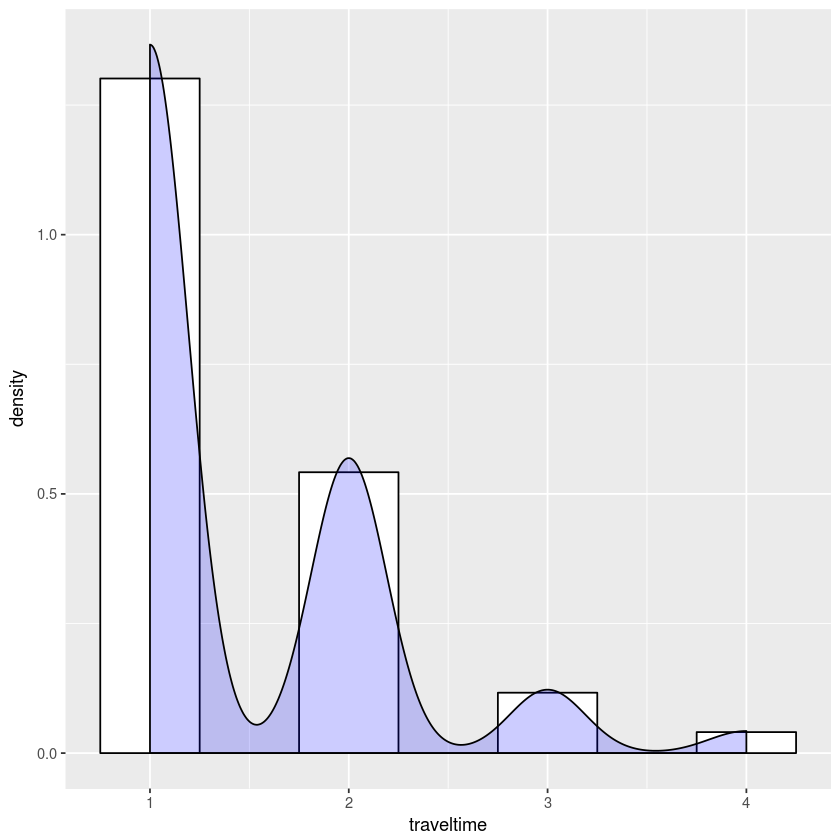

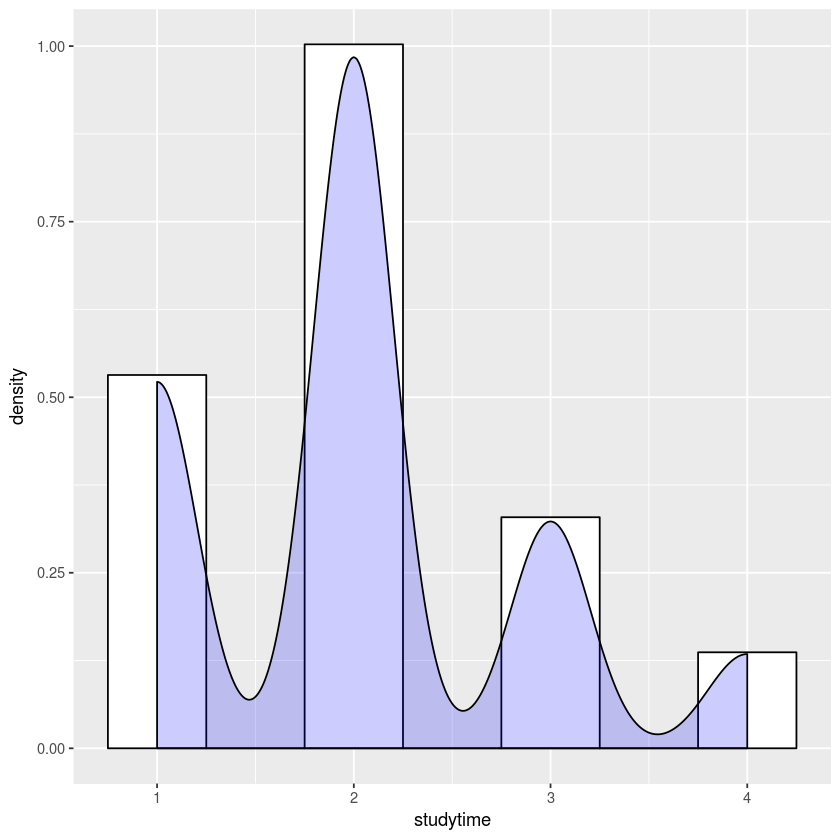

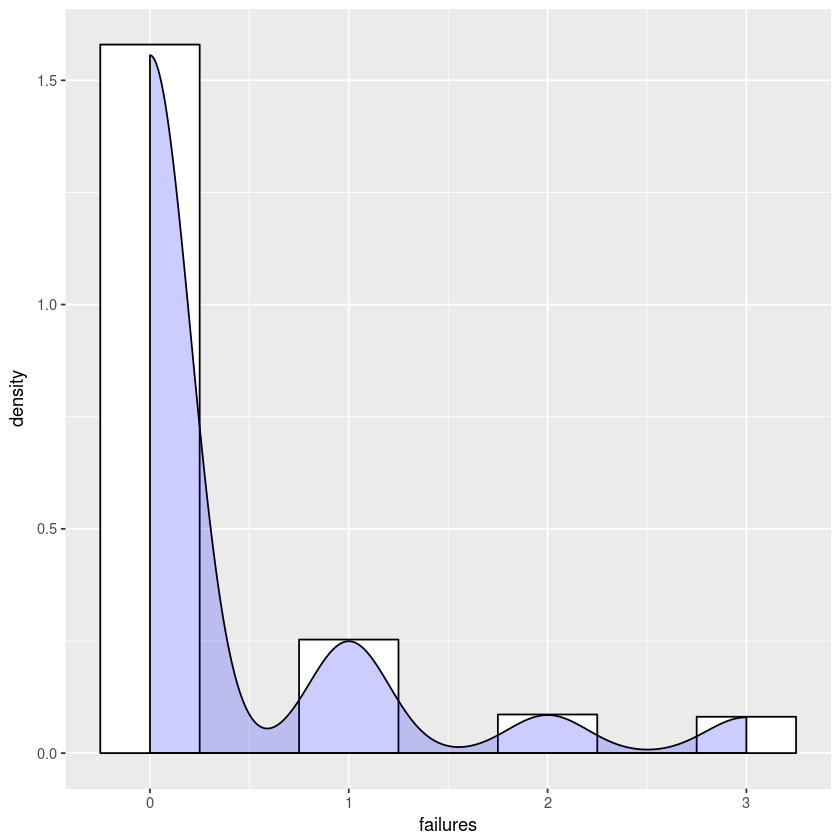

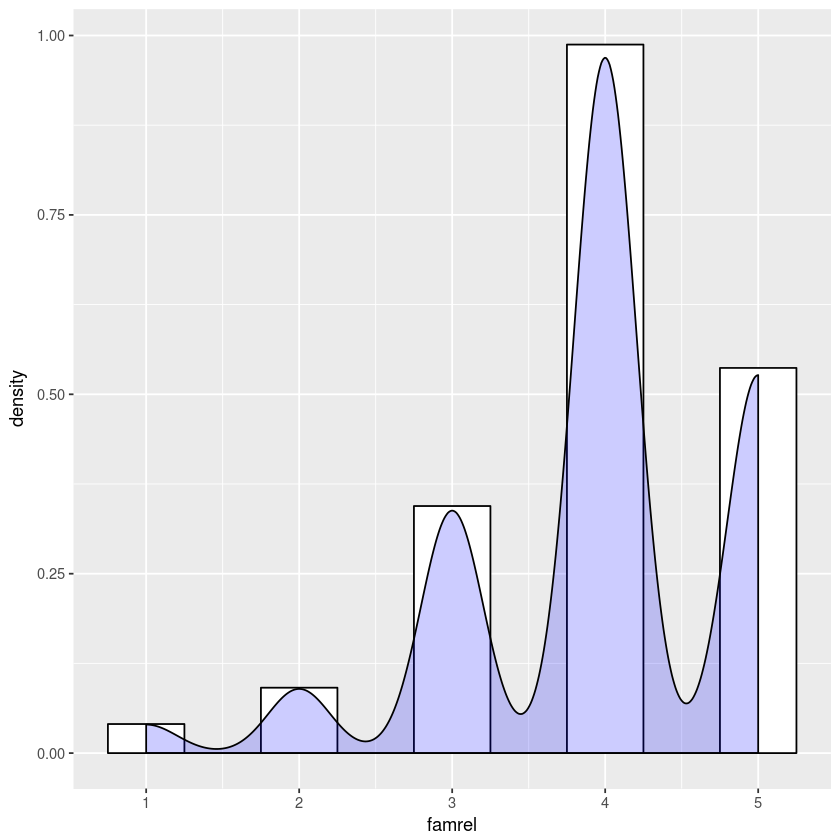

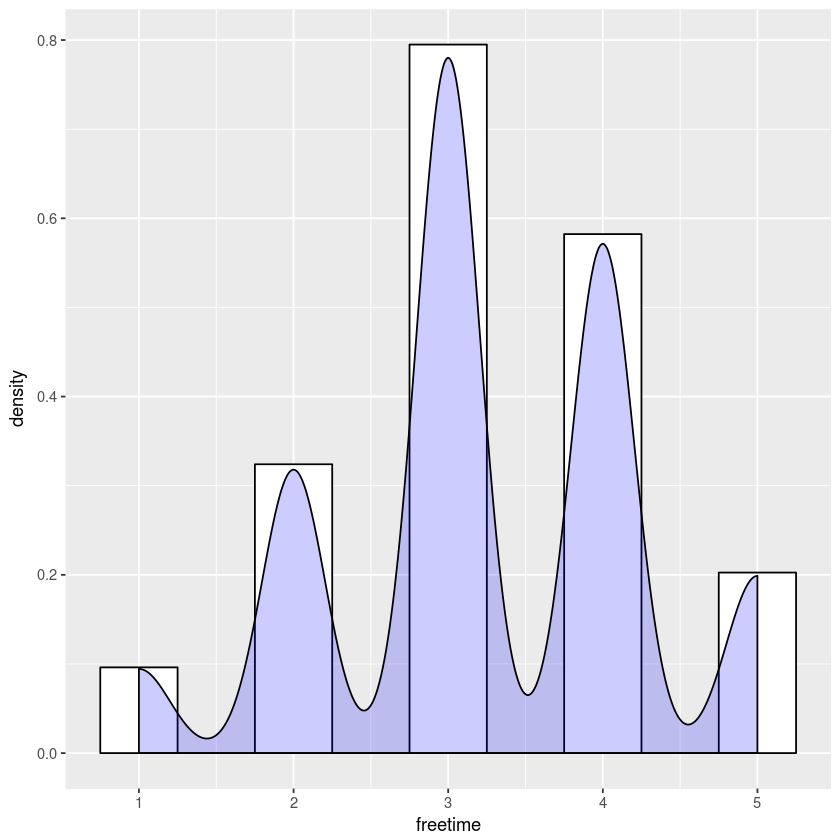

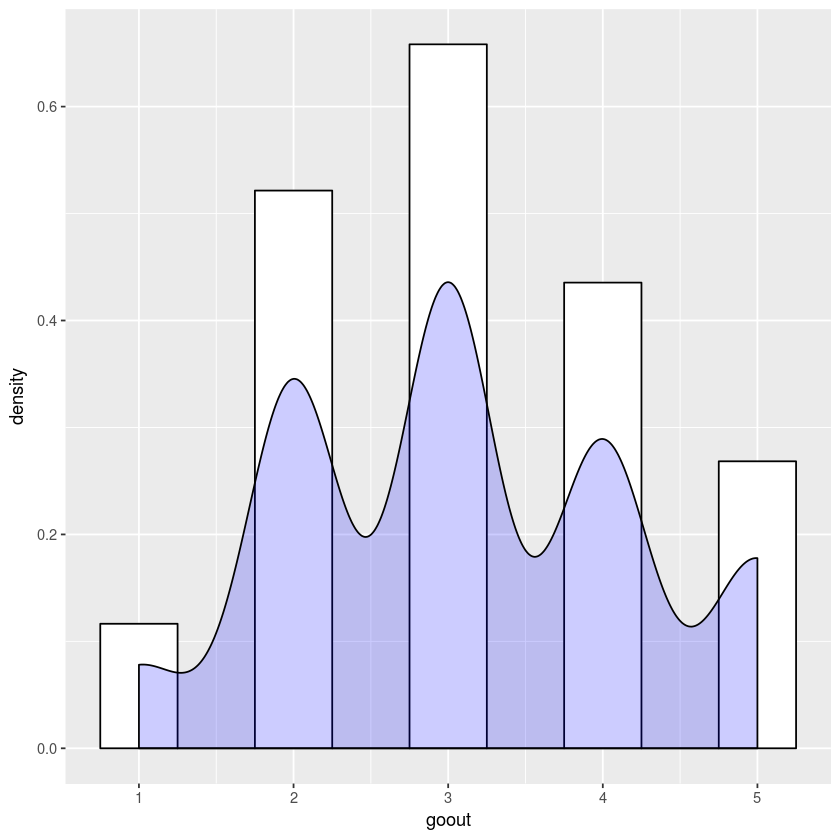

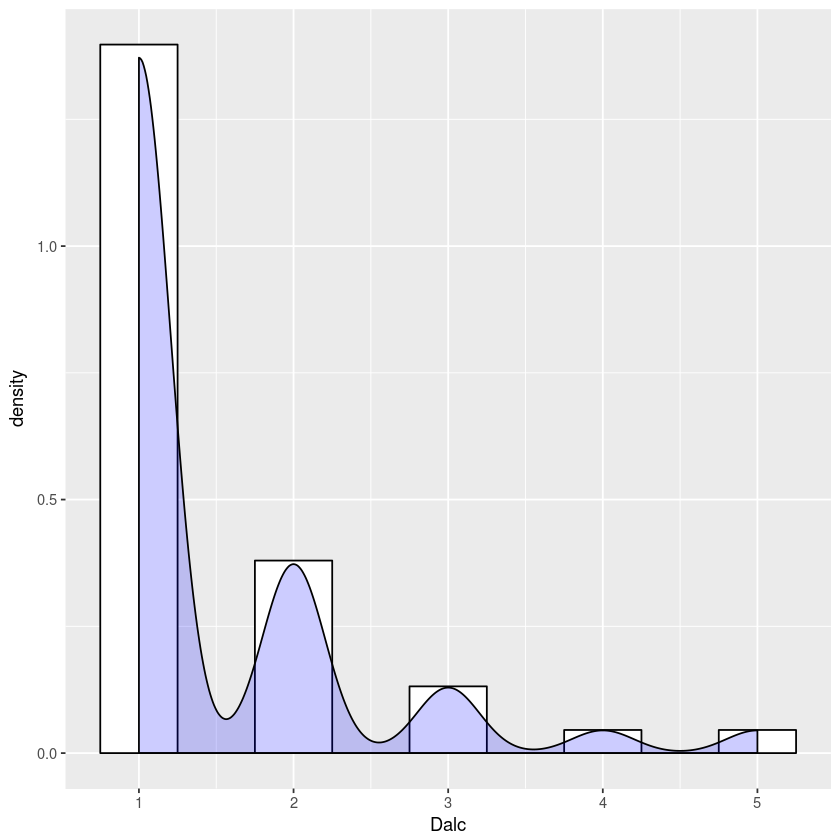

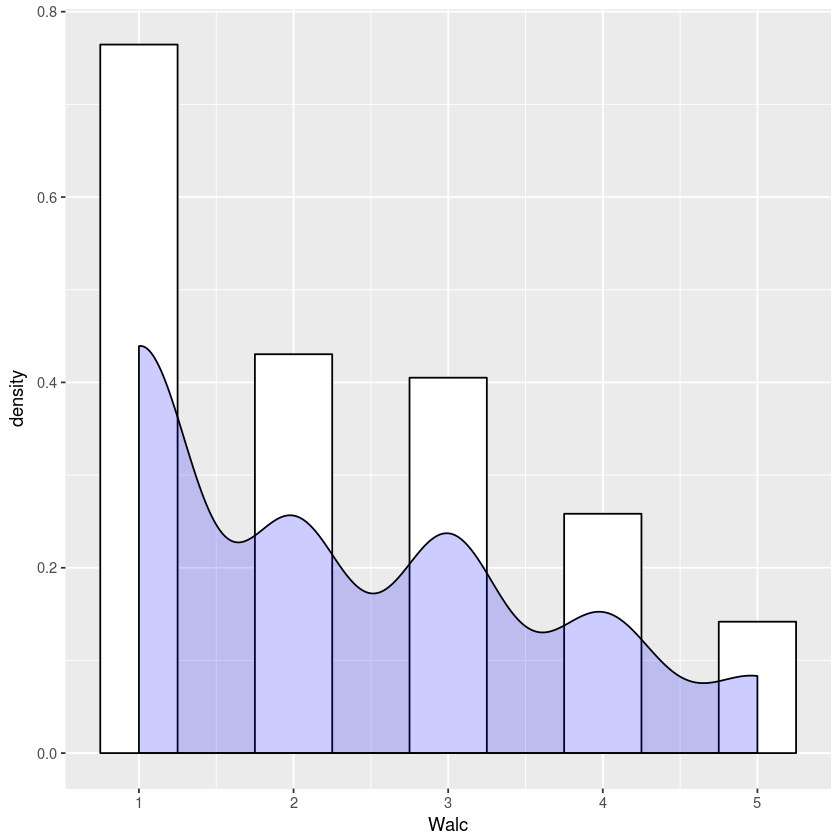

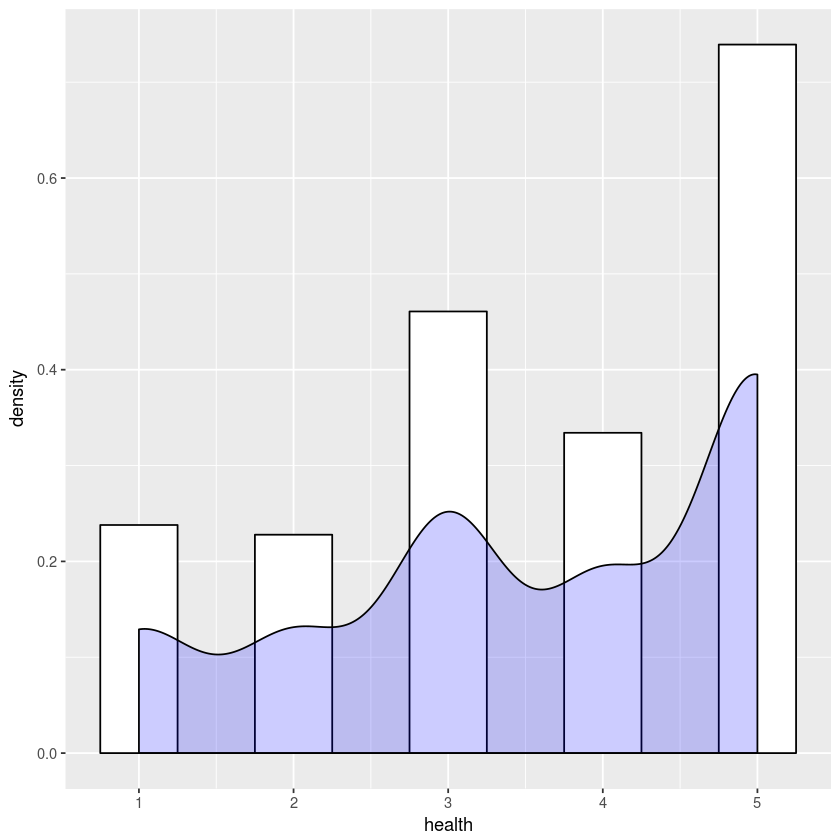

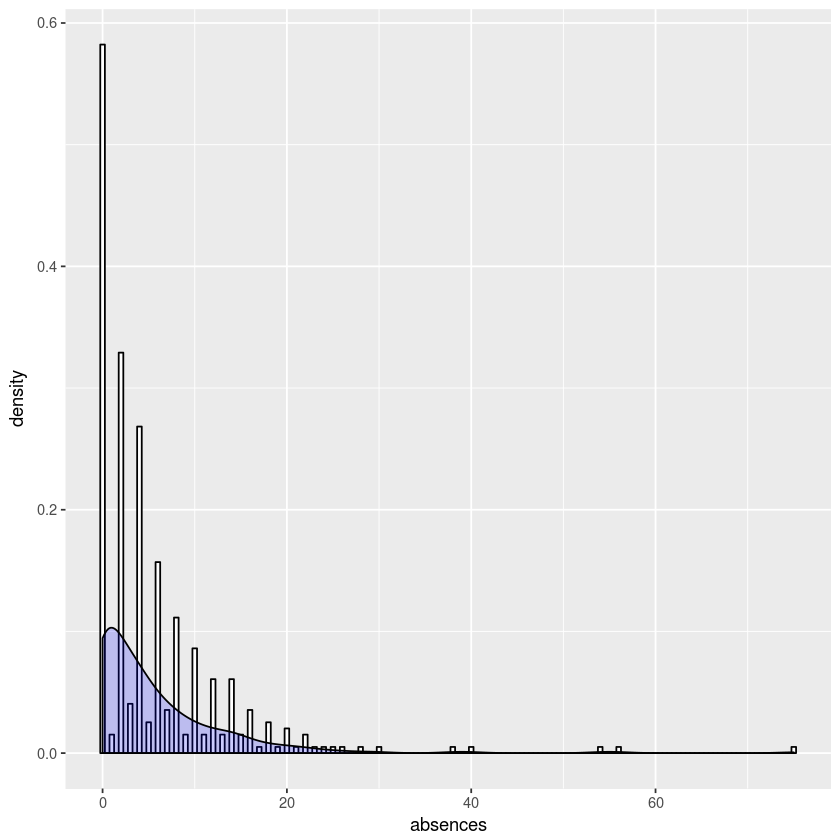

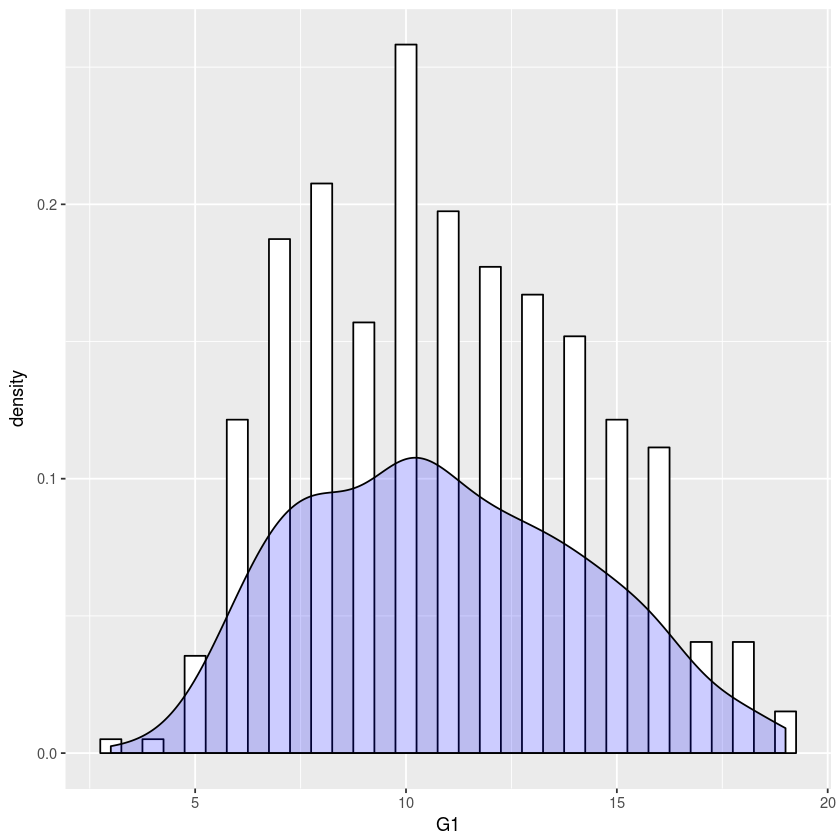

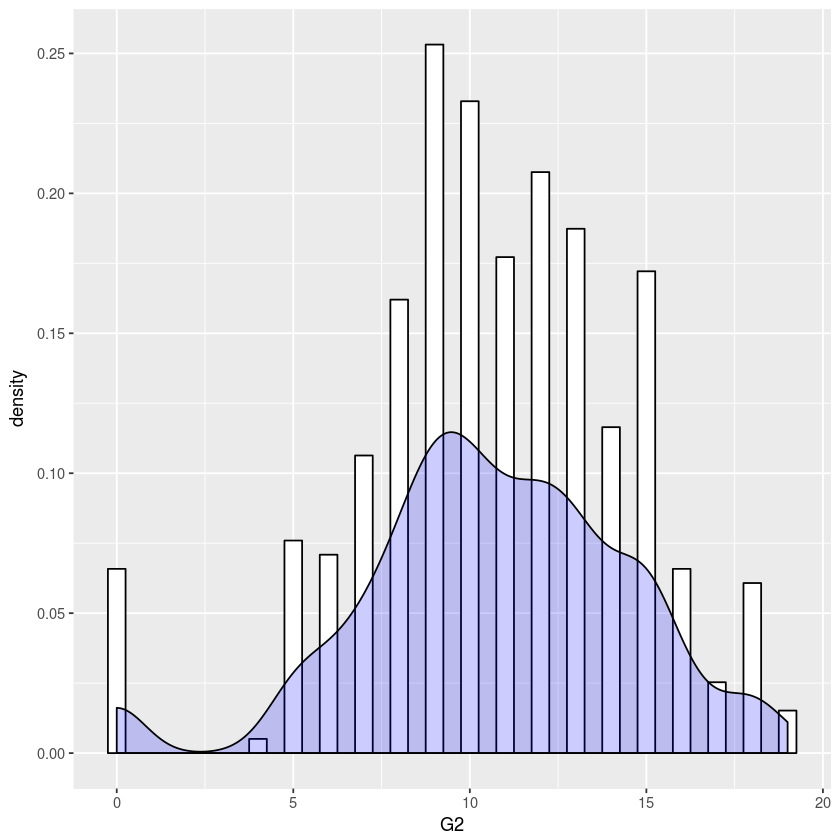

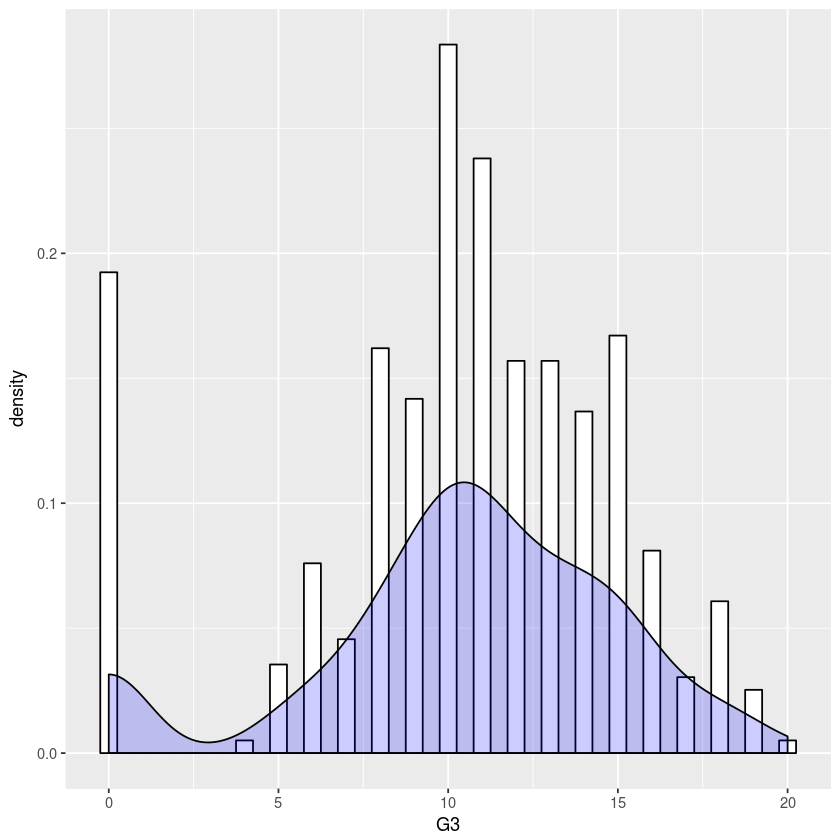

In [9]:
# Math students
for(numeric_col in numeric_cols[numeric_cols != "id_student"]){
  plt <- ggplot(dataset_math, aes_string(x=  numeric_col)) + 
    geom_histogram(aes(y=..density..),
                   binwidth=.5,
                   colour="black", fill="white") +
    geom_density(alpha=.2, fill="blue")  
  print(plt)
}

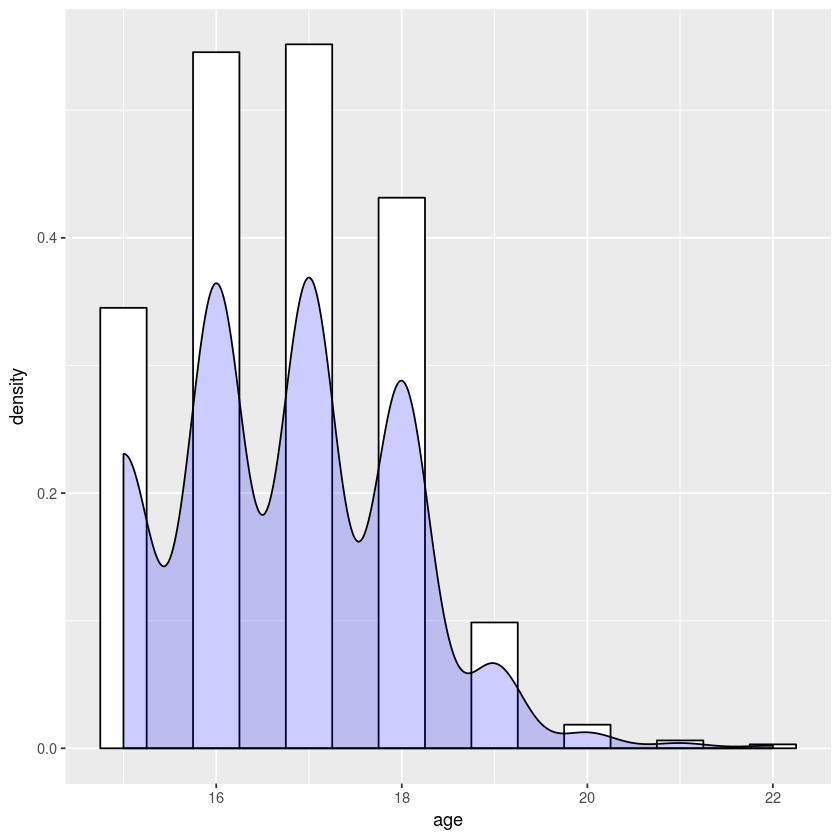

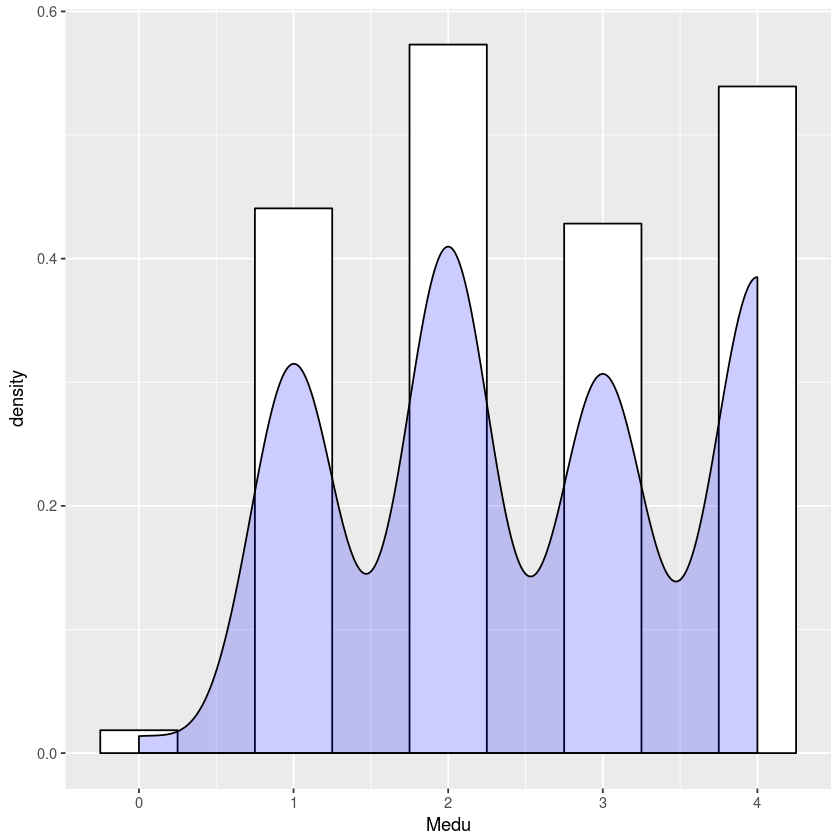

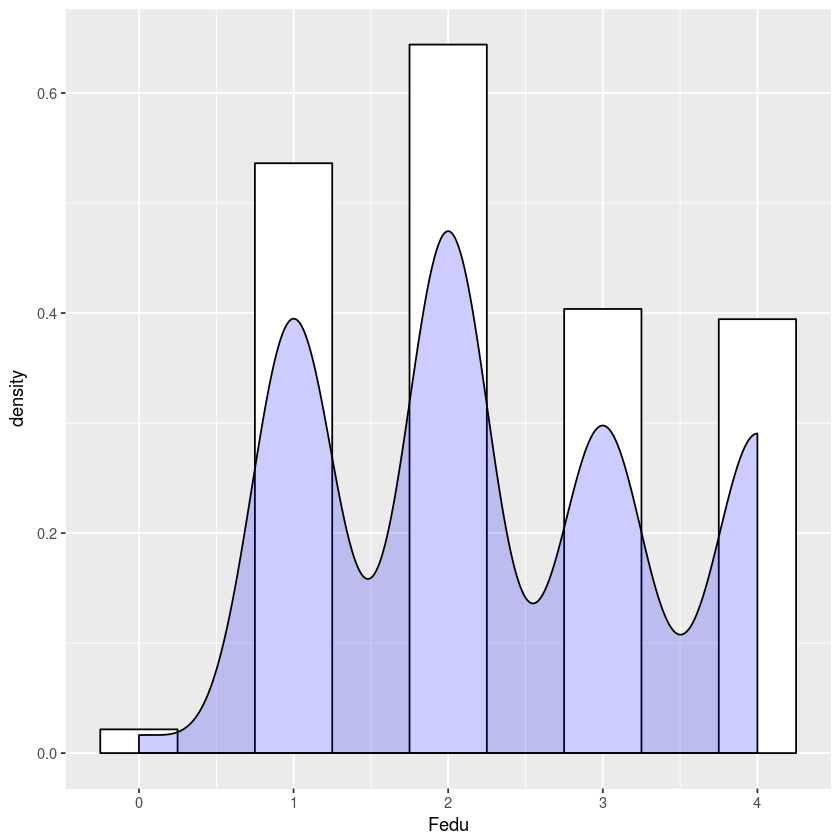

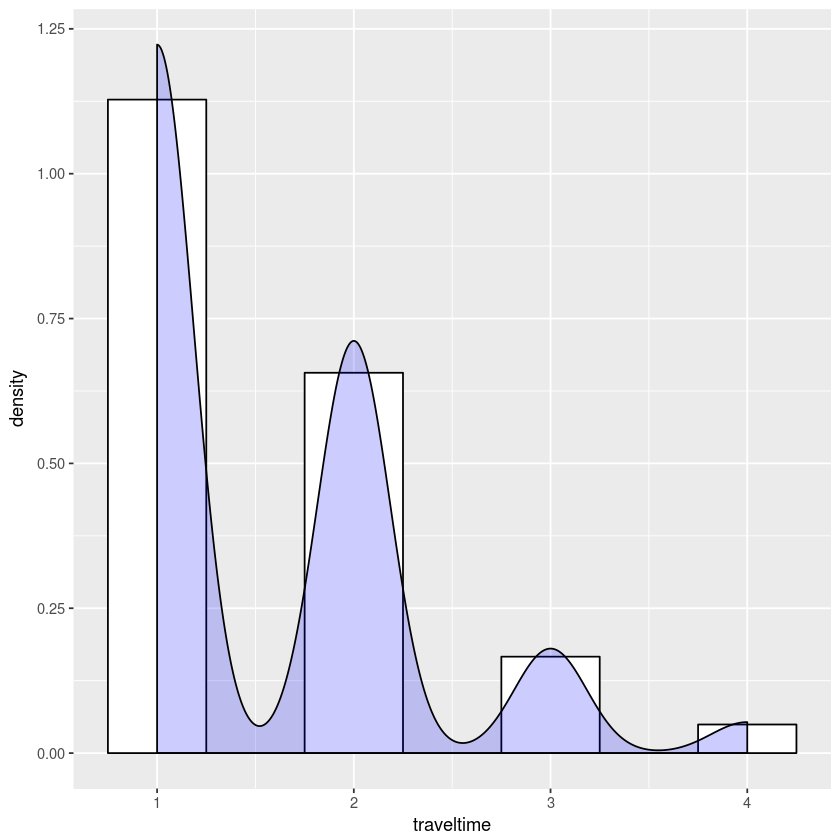

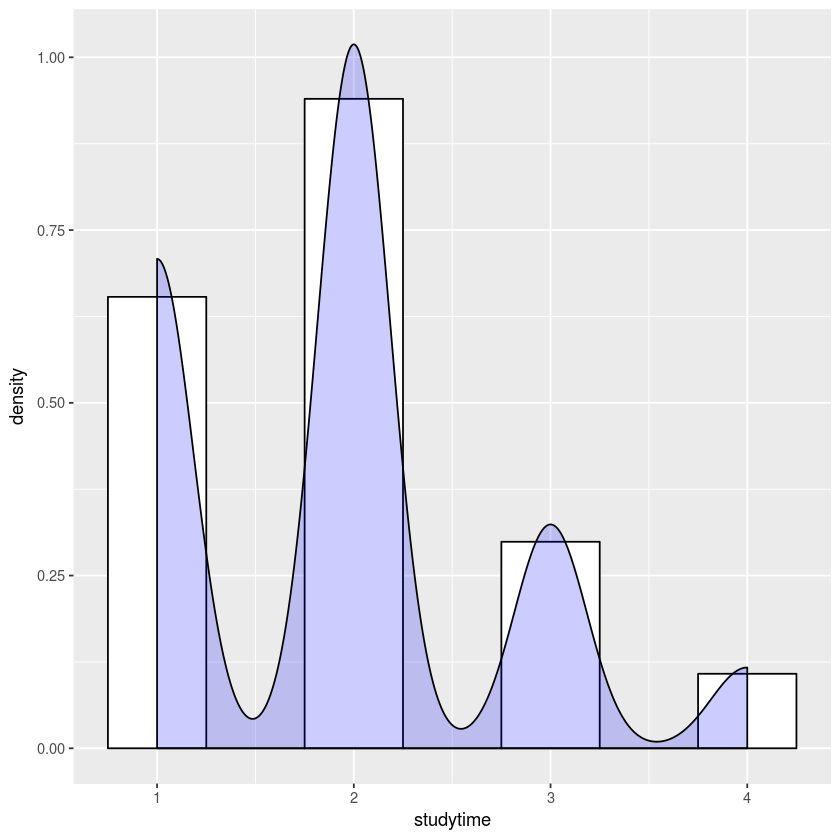

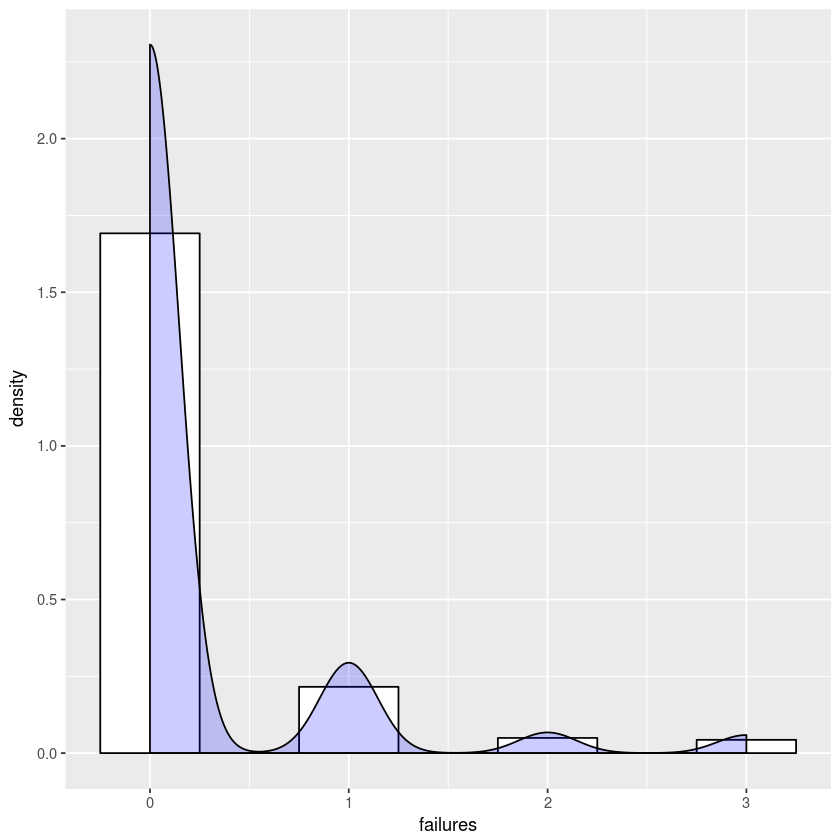

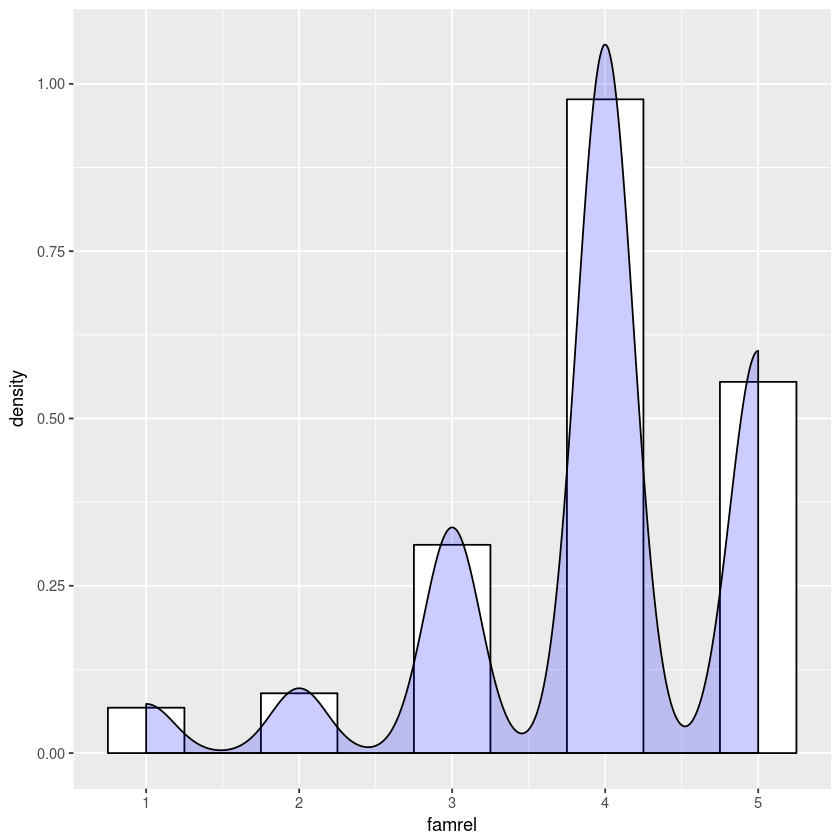

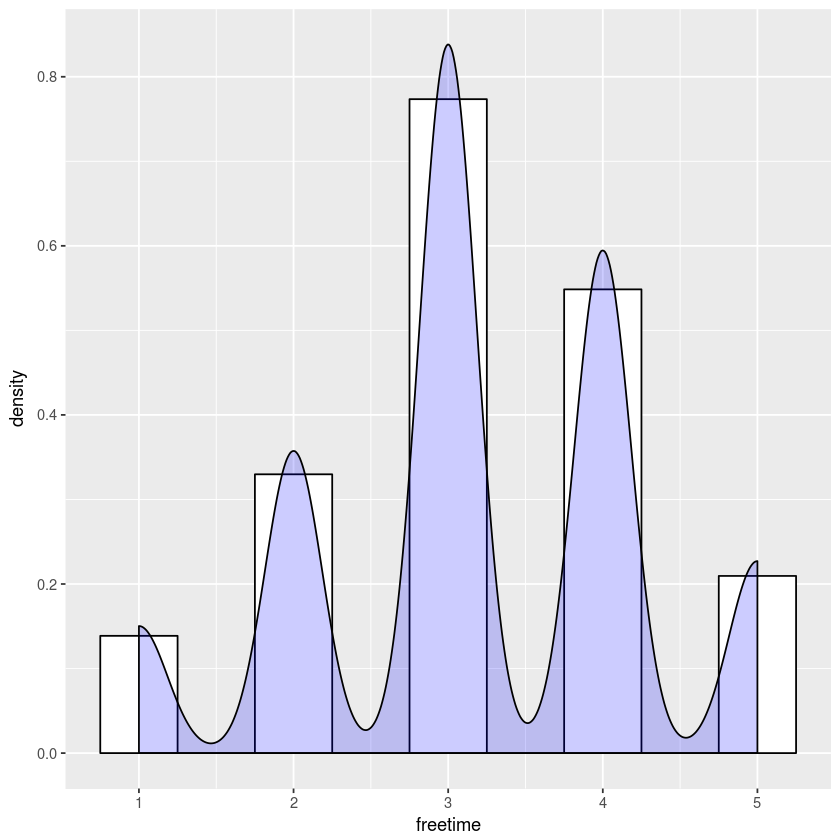

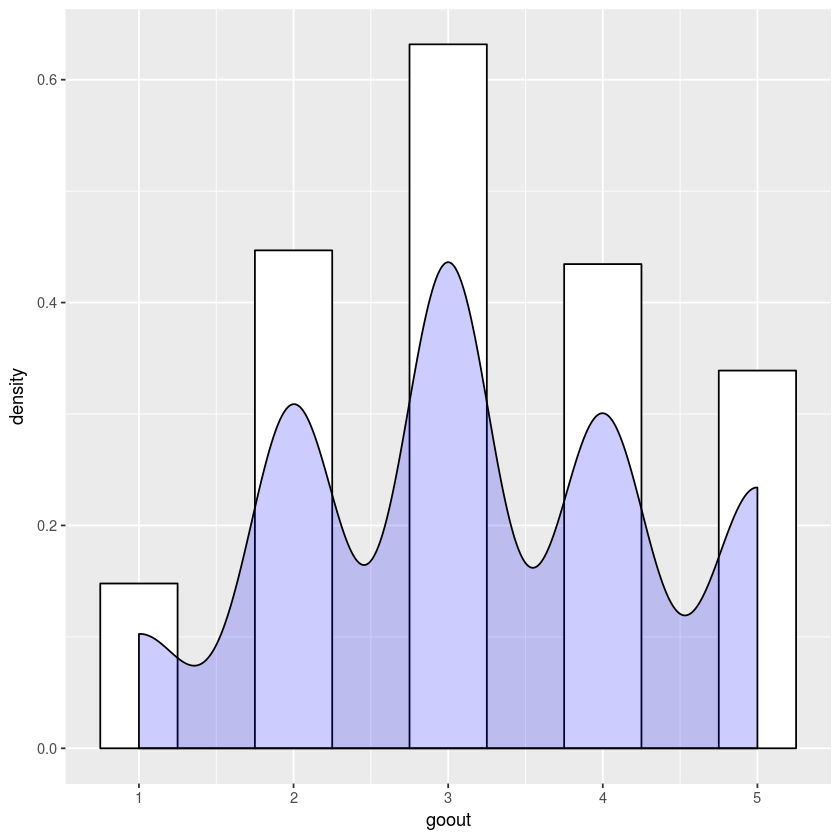

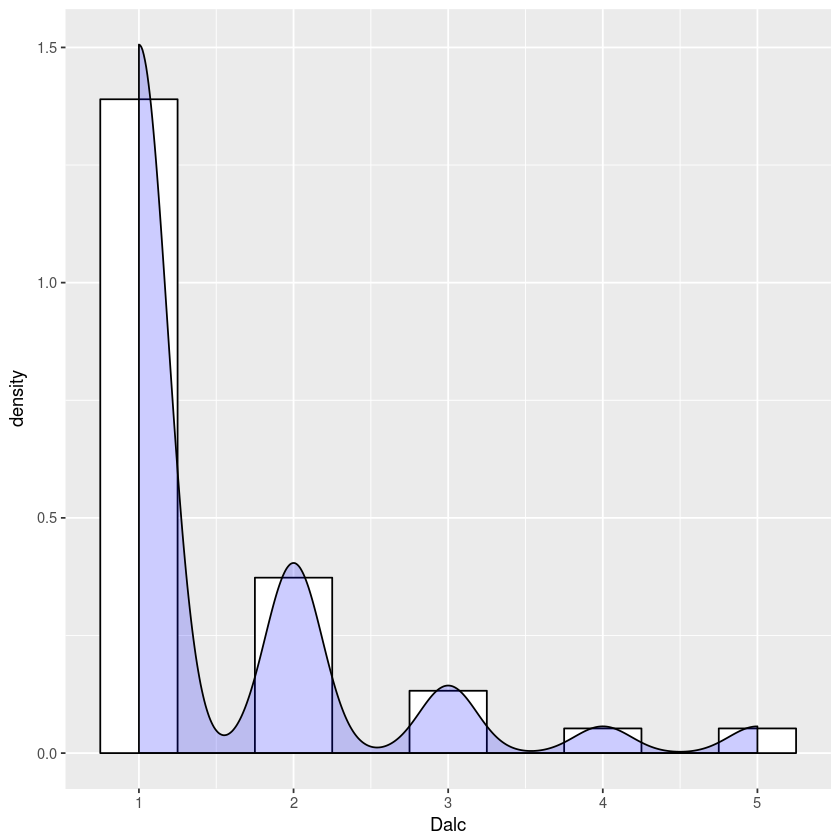

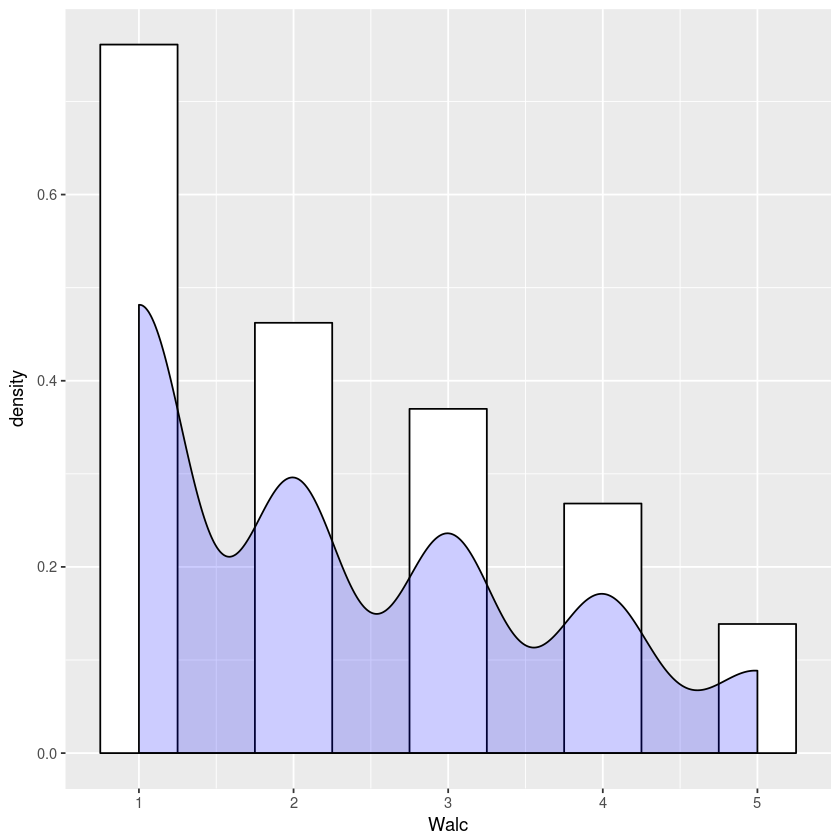

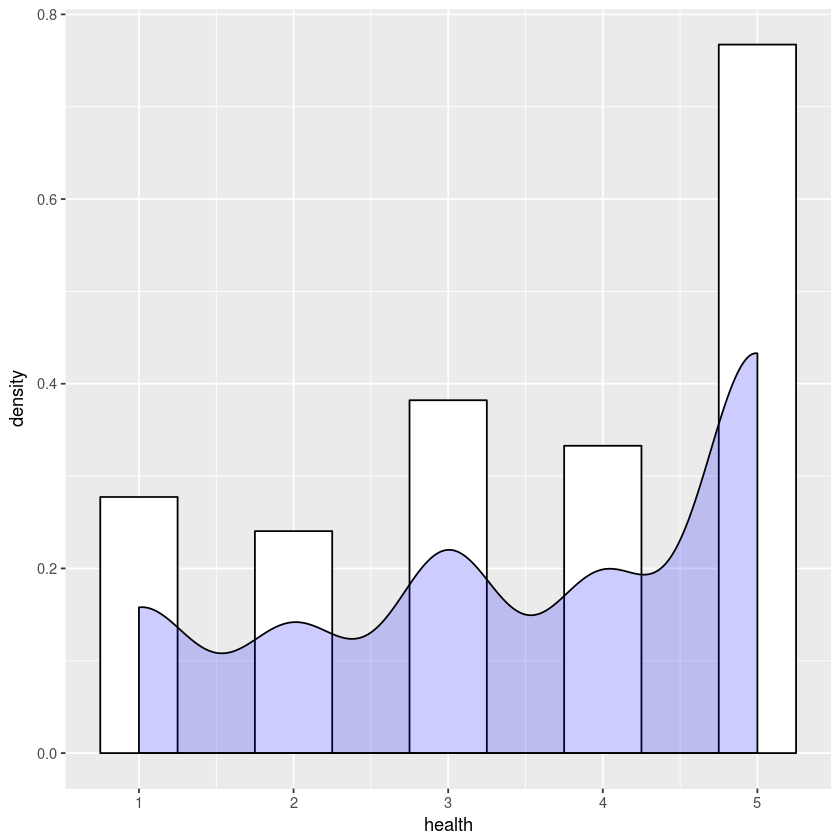

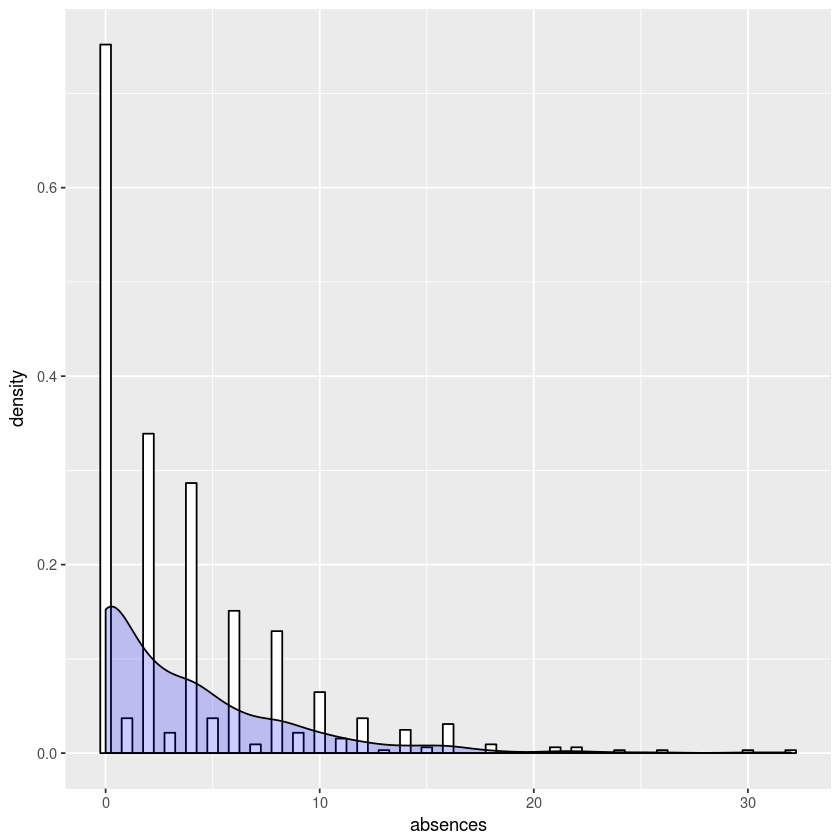

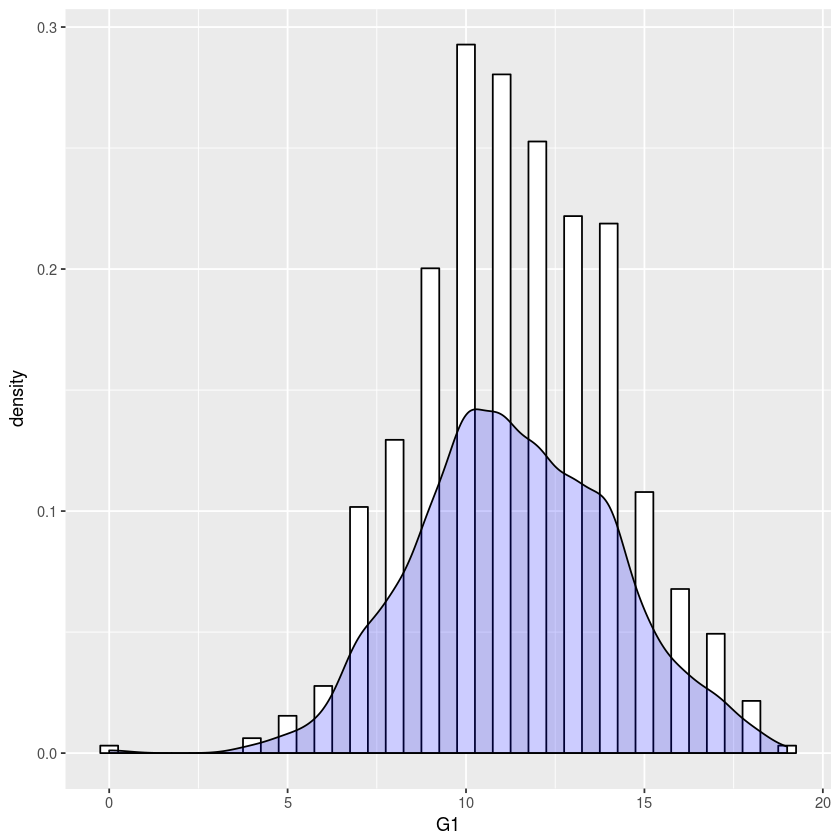

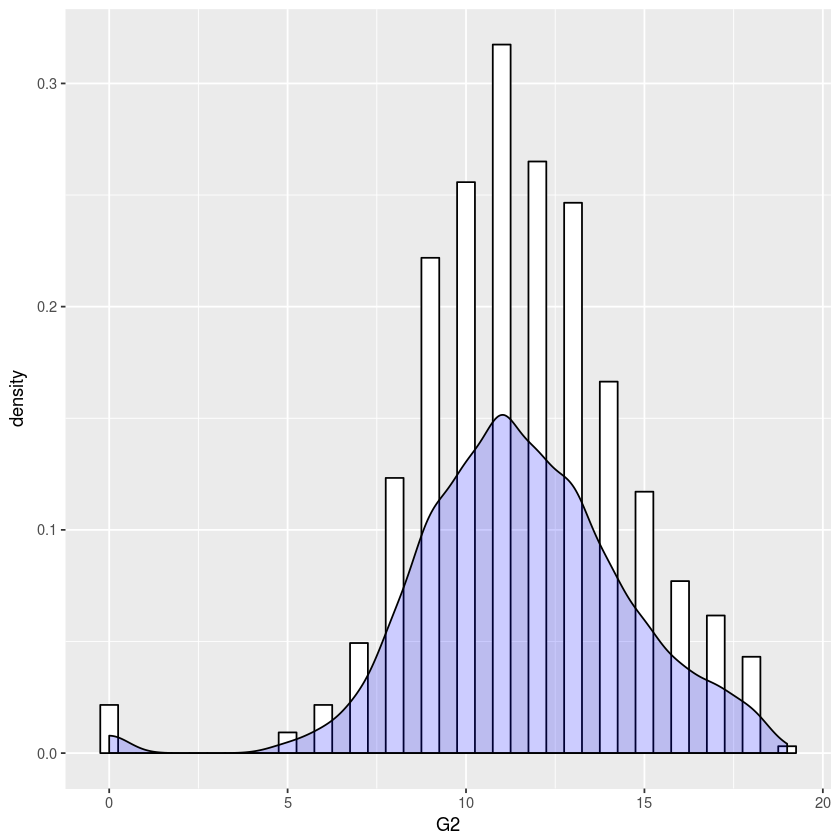

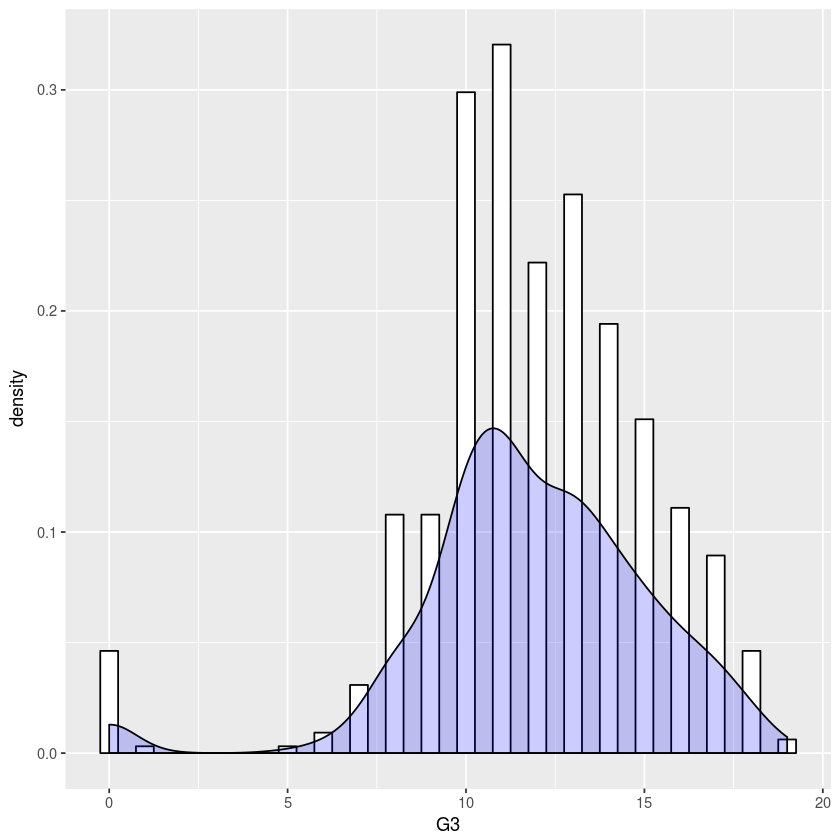

In [10]:
# Portuguese students
for(numeric_col in numeric_cols[numeric_cols != "id_student"]){
  plt <- ggplot(dataset_port, aes_string(x=  numeric_col)) + 
    geom_histogram(aes(y=..density..),
                   binwidth=.5,
                   colour="black", fill="white") +
    geom_density(alpha=.2, fill="blue")  
  print(plt)
}

### NA analysis
- Not a single missing value in the dataset. Great!

In [11]:
print("Math students:")
dataset_math[, lapply(.SD, function(x){ sum(is.na(x)) })]
print("Portuguese students:")
dataset_port[, lapply(.SD, function(x){ sum(is.na(x)) })]

[1] "Math students:"


school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,id_student
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


[1] "Portuguese students:"


school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,id_student
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Conclusions

### Data size and populations:
- Very few records: actually, the dataset is so small that it is not really suitable for any Machine Learning method. Nevertheless, we will use a very simple model and do our best. 
- Since data is so small, Train-Dev-Test split will be a challenge due to small data. We might get lucky ont he split and get a test set where the model does abnormally well, or otherwise. We can try bootstrapping the population, training a model in each sample and averaging the performance of models to have a more robust and reliable, metric. 
- Good intersection of populations. Although the unique identifier is not very reliable
- Two posible ways to deal with these populations:
    * Option 1: We can train one model on each population, or a single model on both populations together. 
    * Option 2: For the second option, we can just add a flag to let the model know what population each record belongs to, and have duplicated observations. This second options might be better, since it lets the model generalize from one population to the other. This technique is particularly good on tree-based models, since they can make an initial split on that flag variable and develop separated trees for each poopulation if necessary (this would be let the model choose whether to choose option 1 or not)

### Data quality:
- Good data quality and integrity
- Categorical features have very few categories, which simplifies data processing
- Small linear correlation between features and targets: a priori, linear methods might not be the best approach. We could will tree-based models with high regularization to avoid overfitting due to small training data. Best way to do this in this case will be limiting tree depth (max depth of 2 or 3)
